PR kali ini merupakan pembuatan model untuk sentiment analysis. Pertama saya set up dulu random seed untuk memastikan repeatibility dari segala prosedur yang ada.

In [ ]:
import random
import numpy as np
import torch

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# Set random seed
set_seed(42)

Kemudian saya lakukan data cleaning mulai dari lowercasing, tokenizing, stemming, stopword removal. Keempat proses tersebut digabung menjadi satu melalui sebuah defined function bernama process_text.

Saya juga akan memetakan sentimen negatif, netral, dan positif menjadi class 0, 1, dan 2.

Karena proses stemming sangat lama, sengaja saya commented agar tidak perlu dilakukan process_text lagi dan langsung saja saya load dataframe yang sudah diproses.

In [ ]:
!pip install Sastrawi
!pip install swifter
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
import swifter
import ast

# Download the 'stopwords' corpus for the 'indonesian' language
nltk.download('stopwords')

# Load stopwords
stop_words = set(nltk.corpus.stopwords.words('indonesian')).union(['nya', 'kan', 'sih'])
stop_words = [i for i in stop_words if i not in ['bagus','baik','kebaikan', 'buruk', 'keburukan', 'jelek', 'kejelekan', 'kejelekkan']]

# Create tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Create Porter stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Function to process text
def process_text(text):
    # Lowercase
    text = str.lower(text)
    # Tokenize
    tokens = tokenizer.tokenize(text)
    # Add 'tidak_' to the stemmed word to prevent the negation word being removed by the stopword remover
    negation = False
    result = []
    for word in tokens:
        if word.lower() in ['tidak', 'bukan', 'tak']:
            negation = not negation
        else:
            result.append('tidak_' + stemmer.stem(word) if negation else stemmer.stem(word))
            negation = False
    # Stopword removal
    processed_text = [token for token in result if token not in stop_words]
    return processed_text

# Function to change sentiment label into integer
def map_labels(label):
    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    return label_mapping[label]

# Read our TSV data and convert into CSV
#train_df = pd.read_csv('train_preprocess.tsv', delimiter='\t', header=None, names=['text_column', 'label_column'])
#valid_df = pd.read_csv('valid_preprocess.tsv', delimiter='\t', header=None, names=['text_column', 'label_column'])
#test_df = pd.read_csv('test_preprocess.tsv', delimiter='\t', header=None, names=['text_column', 'label_column'])

# Process text in each dataframe
#train_df['processed_text'] = train_df['text_column'].swifter.apply(process_text)
#valid_df['processed_text'] = valid_df['text_column'].swifter.apply(process_text)
#test_df['processed_text'] = test_df['text_column'].swifter.apply(process_text)

# Map labels in the dataframes
#train_df['numeric_label'] = train_df['label_column'].swifter.apply(map_labels)
#valid_df['numeric_label'] = valid_df['label_column'].swifter.apply(map_labels)
#test_df['numeric_label'] = test_df['label_column'].swifter.apply(map_labels)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Save DataFrame to a CSV file
#train_df.to_csv('train_df.csv',index=False)
#valid_df.to_csv('valid_df.csv',index=False)
#test_df.to_csv('test_df.csv',index=False)

Berikut saya load dataframe yang sudah terproses.

In [ ]:
train_df=pd.read_csv('train_df.csv')
test_df=pd.read_csv('test_df.csv')
valid_df=pd.read_csv('valid_df.csv')

print(train_df.head())
print(test_df.head())
print(valid_df.head())

                                         text_column label_column  \
0  warung ini dimiliki oleh pengusaha pabrik tahu...     positive   
1  mohon ulama lurus dan k212 mmbri hujjah partai...      neutral   
2  lokasi strategis di jalan sumatera bandung . t...     positive   
3  betapa bahagia nya diri ini saat unboxing pake...     positive   
4  duh . jadi mahasiswa jangan sombong dong . kas...     negative   

                                      processed_text  numeric_label  
0  ['warung', 'milik', 'usaha', 'pabrik', 'puluh'...              2  
1  ['mohon', 'ulama', 'lurus', 'k212', 'mmbri', '...              1  
2  ['lokasi', 'strategis', 'jalan', 'sumatera', '...              2  
3  ['betapa', 'bahagia', 'unboxing', 'paket', 'ba...              2  
4  ['duh', 'mahasiswa', 'sombong', 'kasih', 'kart...              0  
                                         text_column label_column  \
0  kemarin gue datang ke tempat makan baru yang a...     negative   
1  kayak nya sih gue tidak 

Kemudian agar compatible dengan tfidf, saya convert dulu format text pada dataframe menjadi list menggunakan function convert_text_list dibantu library ast. Terakhir saya combine menggunakan function to_sentence.

In [ ]:
import ast
import numpy as np

def convert_text_list(texts):
  texts=ast.literal_eval(texts)
  return [text for text in texts]

def to_sentence(word_list):
    return ' '.join(word_list)

train_df['processed_list']=train_df['processed_text'].apply(convert_text_list)
train_df['combined_list'] = train_df['processed_list'].apply(to_sentence)

valid_df['processed_list']=valid_df['processed_text'].apply(convert_text_list)
valid_df['combined_list'] = valid_df['processed_list'].apply(to_sentence)

test_df['processed_list']=test_df['processed_text'].apply(convert_text_list)
test_df['combined_list'] = test_df['processed_list'].apply(to_sentence)

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                                         text_column label_column  \
0  warung ini dimiliki oleh pengusaha pabrik tahu...     positive   
1  mohon ulama lurus dan k212 mmbri hujjah partai...      neutral   
2  lokasi strategis di jalan sumatera bandung . t...     positive   
3  betapa bahagia nya diri ini saat unboxing pake...     positive   
4  duh . jadi mahasiswa jangan sombong dong . kas...     negative   

                                      processed_text  numeric_label  \
0  ['warung', 'milik', 'usaha', 'pabrik', 'puluh'...              2   
1  ['mohon', 'ulama', 'lurus', 'k212', 'mmbri', '...              1   
2  ['lokasi', 'strategis', 'jalan', 'sumatera', '...              2   
3  ['betapa', 'bahagia', 'unboxing', 'paket', 'ba...              2   
4  ['duh', 'mahasiswa', 'sombong', 'kasih', 'kart...              0   

                                      processed_list  \
0  [warung, milik, usaha, pabrik, puluh, kenal, p...   
1  [mohon, ulama, lurus, k212, mmbri, hujjah, 

Kemudian berikut adalah pembuatan model menggunakan tensorflow. Pertama saya bagi dulu dataframe menjadi x_train, y_train, x_valid, dan y_valid untuk kebutuhan training dan validation saat training. Untuk data x_test dan y_test juga akan dibuat nantinya saat akan melakukan evaluasi model.

Kemudian untuk data independen (x_train dan x_valid) akan diproses menggunakan tfidf vectorizer sebagai quantifier untuk menghitung seberapa pentingnya tiap kata pada data.

Untuk pembuatan model kali ini akan dilakukan hyperparameter tuning menggunakan optuna dimana yang akan dituning adalah jumlah layer (berkisar antara 2-5 layer) dan jumlah neuron per layer.

Pada akhirnya didapat parameter tuning terbaik sebanyak 3 layer dengan detil sebagai berikut: Best Hyperparameters: {'n_layers': 3, 'units_layer_0': 427, 'units_layer_1': 348, 'units_layer_2': 232}

In [ ]:
import numpy as np
!pip install optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
import optuna
from keras.utils import to_categorical

# Create training data
x_train=train_df['combined_list']
y_train=train_df['numeric_label']
x_valid=valid_df['combined_list']
y_valid=valid_df['numeric_label']

# Instantiate the custom callback
class CustomEarlyStopping(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print(f"Epoch {self.stopped_epoch + 1}: Early stopping")

        if self.restore_best_weights and self.best_weights is not None:
            if self.verbose > 0:
                print(f"Restoring model weights from the end of the best epoch: {self.best_epoch + 1}.")
            self.model.set_weights(self.best_weights)
custom_early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Create a TfidfVectorizer and vectorize x
tfidf_vectorizer = TfidfVectorizer()
x_train=tfidf_vectorizer.fit_transform(x_train)
x_valid=tfidf_vectorizer.transform(x_valid)

# Convert y to one hot encoded categorical
y_train = to_categorical(y_train, num_classes=3)
y_valid = to_categorical(y_valid, num_classes=3)

# Initialize global history variable for future plotting
global_history = None

# Objective function for Optuna
def objective(trial):

    global global_history

    # Define the model
    model = Sequential()

    # Flatten layer to handle the input shape
    model.add(Flatten(input_shape=(x_train.shape[1], 1)))

    # Add intermediate dense layers based on the trial suggestion
    for i in range(trial.suggest_int('n_layers', 1, 5)):
        model.add(Dense(units=trial.suggest_int(f'units_layer_{i}', 100, 600), activation='relu'))

    # Add the output layer
    model.add(Dense(units=3, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history=model.fit(x_train.toarray(), y_train, epochs=5, batch_size=32, validation_data=(x_valid.toarray(), y_valid), callbacks=[custom_early_stopping])

    global_history=history

    val_loss = min(history.history['val_loss'])

    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
trial = study.best_trial
print('Best Hyperparameters: {}'.format(trial.params))

# Access the history variable after optimization
final_history = global_history

[I 2023-12-28 12:06:06,229] A new study created in memory with name: no-name-da706b13-6539-4d34-8fed-cc2f1ec178fe


Epoch 1/5
344/344 [==============================] - 8s 9ms/step - loss: 0.4424 - accuracy: 0.8235 - val_loss: 0.3313 - val_accuracy: 0.8810
Epoch 2/5
344/344 [==============================] - 2s 5ms/step - loss: 0.1372 - accuracy: 0.9548 - val_loss: 0.3717 - val_accuracy: 0.8786
Epoch 3/5
344/344 [==============================] - 2s 7ms/step - loss: 0.0453 - accuracy: 0.9871 - val_loss: 0.4943 - val_accuracy: 0.8667
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.5998 - val_accuracy: 0.8683
Epoch 5/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.6835 - val_accuracy: 0.8587
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:06:35,675] Trial 0 finished with value: 0.3312765657901764 and parameters: {'n_layers': 2, 'units_layer_0': 365, 'units_layer_1': 115}. Best is trial 0 with value: 0.3312765657901764.


Epoch 1/5
344/344 [==============================] - 4s 7ms/step - loss: 0.4378 - accuracy: 0.8275 - val_loss: 0.3216 - val_accuracy: 0.8849
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1234 - accuracy: 0.9582 - val_loss: 0.4480 - val_accuracy: 0.8476
Epoch 3/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0342 - accuracy: 0.9888 - val_loss: 0.5524 - val_accuracy: 0.8651
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.7631 - val_accuracy: 0.8706
Epoch 5/5
344/344 [==============================] - 3s 8ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.7673 - val_accuracy: 0.8651
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:06:59,738] Trial 1 finished with value: 0.321591854095459 and parameters: {'n_layers': 3, 'units_layer_0': 427, 'units_layer_1': 348, 'units_layer_2': 232}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 5s 7ms/step - loss: 0.4524 - accuracy: 0.8207 - val_loss: 0.3396 - val_accuracy: 0.8746
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1438 - accuracy: 0.9512 - val_loss: 0.3773 - val_accuracy: 0.8738
Epoch 3/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0398 - accuracy: 0.9873 - val_loss: 0.5932 - val_accuracy: 0.8651
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0136 - accuracy: 0.9957 - val_loss: 0.8597 - val_accuracy: 0.8683
Epoch 5/5
344/344 [==============================] - 3s 7ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 1.0198 - val_accuracy: 0.8746
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:07:24,111] Trial 2 finished with value: 0.3396088480949402 and parameters: {'n_layers': 4, 'units_layer_0': 396, 'units_layer_1': 130, 'units_layer_2': 560, 'units_layer_3': 289}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 5s 6ms/step - loss: 0.4639 - accuracy: 0.8161 - val_loss: 0.3573 - val_accuracy: 0.8722
Epoch 2/5
344/344 [==============================] - 2s 5ms/step - loss: 0.1552 - accuracy: 0.9469 - val_loss: 0.3640 - val_accuracy: 0.8738
Epoch 3/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0446 - accuracy: 0.9850 - val_loss: 0.7118 - val_accuracy: 0.8476
Epoch 4/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0144 - accuracy: 0.9955 - val_loss: 0.7719 - val_accuracy: 0.8706
Epoch 5/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 0.9084 - val_accuracy: 0.8627
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:07:48,100] Trial 3 finished with value: 0.3572653532028198 and parameters: {'n_layers': 4, 'units_layer_0': 159, 'units_layer_1': 399, 'units_layer_2': 274, 'units_layer_3': 456}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 6s 8ms/step - loss: 0.4678 - accuracy: 0.8149 - val_loss: 0.3843 - val_accuracy: 0.8556
Epoch 2/5
344/344 [==============================] - 3s 9ms/step - loss: 0.1633 - accuracy: 0.9465 - val_loss: 0.3789 - val_accuracy: 0.8690
Epoch 3/5
344/344 [==============================] - 3s 7ms/step - loss: 0.0453 - accuracy: 0.9854 - val_loss: 0.6899 - val_accuracy: 0.8675
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.7730 - val_accuracy: 0.8643
Epoch 5/5
344/344 [==============================] - 3s 8ms/step - loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.7602 - val_accuracy: 0.8683
Restoring model weights from the end of the best epoch: 2.


[I 2023-12-28 12:08:11,917] Trial 4 finished with value: 0.37887927889823914 and parameters: {'n_layers': 5, 'units_layer_0': 342, 'units_layer_1': 371, 'units_layer_2': 488, 'units_layer_3': 295, 'units_layer_4': 568}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 4s 8ms/step - loss: 0.4406 - accuracy: 0.8225 - val_loss: 0.3280 - val_accuracy: 0.8810
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1321 - accuracy: 0.9554 - val_loss: 0.4142 - val_accuracy: 0.8667
Epoch 3/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0377 - accuracy: 0.9890 - val_loss: 0.5245 - val_accuracy: 0.8587
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0131 - accuracy: 0.9965 - val_loss: 0.6110 - val_accuracy: 0.8635
Epoch 5/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.7519 - val_accuracy: 0.8659
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:08:26,371] Trial 5 finished with value: 0.32795003056526184 and parameters: {'n_layers': 2, 'units_layer_0': 496, 'units_layer_1': 434}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 4s 9ms/step - loss: 0.4574 - accuracy: 0.8144 - val_loss: 0.3240 - val_accuracy: 0.8810
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1564 - accuracy: 0.9498 - val_loss: 0.3656 - val_accuracy: 0.8754
Epoch 3/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0658 - accuracy: 0.9806 - val_loss: 0.4140 - val_accuracy: 0.8667
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0325 - accuracy: 0.9918 - val_loss: 0.4818 - val_accuracy: 0.8635
Epoch 5/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0182 - accuracy: 0.9951 - val_loss: 0.5356 - val_accuracy: 0.8579
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:08:49,658] Trial 6 finished with value: 0.32404541969299316 and parameters: {'n_layers': 1, 'units_layer_0': 539}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 4s 7ms/step - loss: 0.4665 - accuracy: 0.8129 - val_loss: 0.3258 - val_accuracy: 0.8810
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1470 - accuracy: 0.9490 - val_loss: 0.3675 - val_accuracy: 0.8802
Epoch 3/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0462 - accuracy: 0.9845 - val_loss: 0.4897 - val_accuracy: 0.8698
Epoch 4/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 0.6736 - val_accuracy: 0.8619
Epoch 5/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.7917 - val_accuracy: 0.8595


[I 2023-12-28 12:09:02,832] Trial 7 finished with value: 0.32581984996795654 and parameters: {'n_layers': 3, 'units_layer_0': 132, 'units_layer_1': 168, 'units_layer_2': 132}. Best is trial 1 with value: 0.321591854095459.


Restoring model weights from the end of the best epoch: 1.
Epoch 1/5
344/344 [==============================] - 4s 7ms/step - loss: 0.4489 - accuracy: 0.8205 - val_loss: 0.3338 - val_accuracy: 0.8857
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1434 - accuracy: 0.9529 - val_loss: 0.3843 - val_accuracy: 0.8714
Epoch 3/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.5097 - val_accuracy: 0.8738
Epoch 4/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.7317 - val_accuracy: 0.8643
Epoch 5/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.7688 - val_accuracy: 0.8722
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:09:26,395] Trial 8 finished with value: 0.3338426351547241 and parameters: {'n_layers': 3, 'units_layer_0': 171, 'units_layer_1': 254, 'units_layer_2': 224}. Best is trial 1 with value: 0.321591854095459.


Epoch 1/5
344/344 [==============================] - 5s 9ms/step - loss: 0.4480 - accuracy: 0.8266 - val_loss: 0.3555 - val_accuracy: 0.8786
Epoch 2/5
344/344 [==============================] - 2s 7ms/step - loss: 0.1522 - accuracy: 0.9498 - val_loss: 0.4015 - val_accuracy: 0.8587
Epoch 3/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0368 - accuracy: 0.9890 - val_loss: 0.6744 - val_accuracy: 0.8667
Epoch 4/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.6570 - val_accuracy: 0.8643
Epoch 5/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0072 - accuracy: 0.9980 - val_loss: 1.1150 - val_accuracy: 0.8683
Restoring model weights from the end of the best epoch: 1.


[I 2023-12-28 12:09:50,232] Trial 9 finished with value: 0.3554740250110626 and parameters: {'n_layers': 5, 'units_layer_0': 404, 'units_layer_1': 328, 'units_layer_2': 275, 'units_layer_3': 600, 'units_layer_4': 564}. Best is trial 1 with value: 0.321591854095459.


Best Hyperparameters: {'n_layers': 3, 'units_layer_0': 427, 'units_layer_1': 348, 'units_layer_2': 232}


Berikut adalah plot learning curvenya. Terlihat bahwa penambahan epoch hanya meningkatkan performance training namun tidak pada testing. Hal ini disebabkan karena penambahan epoch akan membuat model semakin memahami data training, namun tidak mampu digeneralisasikan ke validation sehingga terjadi sedikit overfitting.

Menurut saya, overfitting ini disebabkan karena data yang masih kurang bersih. Meskipun sudah dilakukan proses cleaning standar, namun belum dilakukan typo/misspelling checking.

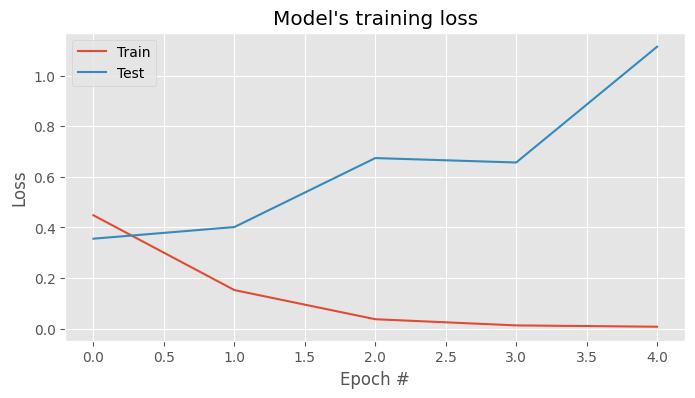

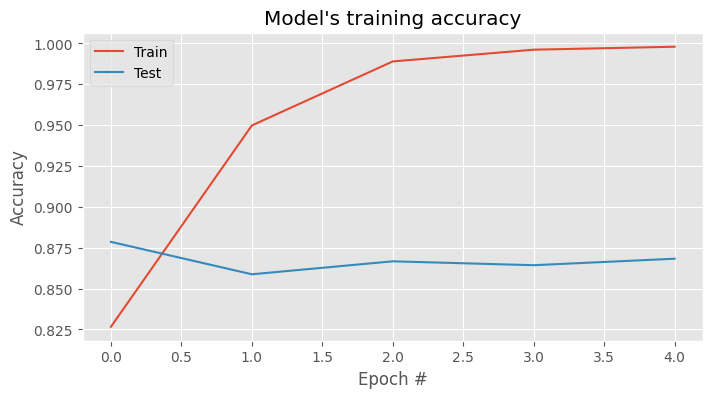

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Model's training loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def plot_accuracy(history):
    plt.style.use("ggplot")
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model's training accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_loss(final_history)
plot_accuracy(final_history)

In [ ]:
model = Sequential()

# Flatten layer to handle the input shape
model.add(Flatten(input_shape=(x_train.shape[1], 1)))

# Add intermediate dense layers based on the trial suggestion
for i in range(trial.params['n_layers']):
    model.add(Dense(units=trial.params[f'units_layer_{i}'], activation='relu'))

# Add the output layer
model.add(Dense(units=3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 13681)             0         
                                                                 
 dense_46 (Dense)            (None, 427)               5842214   
                                                                 
 dense_47 (Dense)            (None, 348)               148944    
                                                                 
 dense_48 (Dense)            (None, 232)               80968     
                                                                 
 dense_49 (Dense)            (None, 3)                 699       
                                                                 
Total params: 6072825 (23.17 MB)
Trainable params: 6072825 (23.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model diatas akan saya coba terapkan ke data validation terlebih dahulu untuk melihat confusion matrix dan classification reportnya.

Terlihat bahwa baik akurasi, presisi, f1-score maupun recallnhya sudah cukup baik, kecuali untuk class 1. Hal ini disebabkan karena support untuk class 1 paling sedikit jumlahnya (pada saat training) sehingga model belum terlalu mengenali data seperti apa yang dapat dikategorikan sebagai class 1.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

model.fit(x_train.toarray(), y_train, epochs=5, batch_size=32, validation_data=(x_valid.toarray(), y_valid), callbacks=[custom_early_stopping])
pred=model.predict(x_valid.toarray())
print(confusion_matrix(y_valid.argmax(axis=1), pred.argmax(axis=1)))
print(classification_report(y_valid.argmax(axis=1), pred.argmax(axis=1)))

Epoch 1/5
344/344 [==============================] - 5s 8ms/step - loss: 0.4380 - accuracy: 0.8216 - val_loss: 0.3244 - val_accuracy: 0.8786
Epoch 2/5
344/344 [==============================] - 2s 6ms/step - loss: 0.1370 - accuracy: 0.9538 - val_loss: 0.3969 - val_accuracy: 0.8810
Epoch 3/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.5494 - val_accuracy: 0.8675
Epoch 4/5
344/344 [==============================] - 2s 5ms/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 0.6773 - val_accuracy: 0.8595
Epoch 5/5
344/344 [==============================] - 2s 6ms/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.8745 - val_accuracy: 0.8627
Restoring model weights from the end of the best epoch: 1.
40/40 [==============================] - 0s 2ms/step
[[331  16  47]
 [ 18  96  17]
 [ 27  28 680]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       394
           1       0.69     

Terakhir, kita akan coba model kita pada data test untuk mensimulasikan data unseen (meskipun kali ini sudah ada ground truth nya).

Terlihat bahwa sama kasusnya seperti pada data validation, class 1 memiliki performa prediksi terburuk karena saat training model belum begitu mengenali class 1.

In [ ]:
x_test=test_df['combined_list']
y_test=test_df['numeric_label']

x_test=tfidf_vectorizer.transform(x_test)
y_test = to_categorical(y_test, num_classes=3)

pred=model.predict(x_test.toarray())
print(confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1)))

16/16 [==============================] - 0s 2ms/step
[[180  12  12]
 [ 14  60  14]
 [ 24  19 165]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       204
           1       0.66      0.68      0.67        88
           2       0.86      0.79      0.83       208

    accuracy                           0.81       500
   macro avg       0.78      0.79      0.78       500
weighted avg       0.81      0.81      0.81       500



Kesimpulannya, model dapat ditingkatkan dengan cleaning data yang lebih advanced, salah satunya adalah typo checking. Selain itu penyeimbangan jumlah data training untuk ketiga class juga dapat membuat model lebih mengenali seluruh class dan meningkatkan kualitas prediksi secara keseluruhan.